>    **KNN on Amazon Fine Foods Reviews**

**Objective** - Run KNN Algorithms on Amazon Fine Foods Review Dataset using BoW,TF-IDF,Avg Word2Vec and TF-IDF weighed Word2Vec vectorization methods. Also to report the metrics for each iteration. Time based splitting to be followed.


**KNN Algorithms to be used** - KD TREE and BRUTE

**Kaggle Dataset Location** - https://www.kaggle.com/snap/amazon-fine-food-reviews/data



**1. Importing required packages**

In [1]:
# import packages
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
import sqlite3
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import SnowballStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,classification_report,f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn import cross_validation
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from sklearn.model_selection import train_test_split
from tqdm import tqdm

/usr/lib/python3/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


**2. Importing Dataset from database.sqlite and ignoring reviews with Score  = 3 as they represent a neutral view**

In [2]:
# creating sql connection string
con = sqlite3.connect('AmazonReviews.sqlite')

In [3]:
#Positive Review - Rating above 3
#Negative Review - Rating below 3
#Ignoring Reviews with 3 Rating

filtered_data = pd.read_sql_query('SELECT * from Reviews WHERE Score != 3',con)

In [4]:
# mapping ratings above 3 as Positive and below 3 as Negative

actual_scores = filtered_data['Score']
positiveNegative = actual_scores.map(lambda x: 'Positive' if x>3 else 'Negative')
filtered_data['Score'] = positiveNegative

In [5]:
filtered_data.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,Positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,Negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,Positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,Negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,Positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


**3. Data Preprocessing**

In [6]:
final = filtered_data.drop_duplicates(subset= { 'UserId', 'ProfileName', 'Time',  'Text'})

In [7]:
print('Rows dropped : ',filtered_data.size - final.size)
print('Percentage Data remaining after dropping duplicates :',(((final.size * 1.0)/(filtered_data.size * 1.0) * 100.0)))

Rows dropped :  1616410
Percentage Data remaining after dropping duplicates : 69.25890143662969


In [8]:
# Dropping rows where HelpfulnessNumerator < HelpfulnessDenominator
final = final[final.HelpfulnessDenominator >= final.HelpfulnessNumerator]

In [9]:
print('Number of Rows remaining in the Dataset: ',final.size)

Number of Rows remaining in the Dataset:  3641710


In [10]:
# Checking the number of positive and negative reviews
final['Score'].value_counts()

Positive    307061
Negative     57110
Name: Score, dtype: int64

In [11]:
# Data Sampling
final = final.iloc[:50000,:]

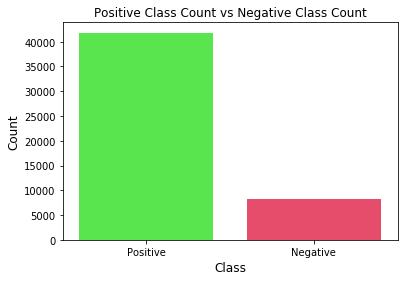

Positive    41815
Negative     8185
Name: Score, dtype: int64


In [12]:
# Checking the number of positive and negative reviews

Class_Count  = final['Score'].value_counts()

plt.figure()
flatui = ["#15ff00", "#ff0033"]
sns.set_palette(flatui)
sns.barplot(Class_Count.index, Class_Count.values, alpha=0.8 )
plt.title('Positive Class Count vs Negative Class Count')
plt.ylabel('Count', fontsize=12)
plt.xlabel('Class', fontsize=12)
plt.show()

print(final['Score'].value_counts())

In [13]:
# Sorting values according to Time for Time Based Slicing
final = final.sort_values('Time',kind = 'quicksort')

#### 4. Cleaning Data - Stop Words Removal,Stemming,Removing HTML tags and Special Characters

In [14]:
# Function to Remove HTML Tags
def cleanhtml(sentence):
    cleaner = re.compile('<.*?>')
    cleantext = re.sub(cleaner,"",sentence)
    return cleantext

In [15]:
# Function to clean punctuations and special characters

def cleanpunct(sentence):
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned


In [16]:
# Initialize Stop words and PorterStemmer and Lemmetizer
stop = set(stopwords.words('english'))
sno = SnowballStemmer('english')


#print(stop)
#print('*' * 100)
#print(sno.stem('tasty'))

In [17]:

# Cleaning HTML and non-Alphanumeric characters from the review text
i=0
str1=' '
final_string=[]
all_positive_words=[] # store words from +ve reviews here
all_negative_words=[] # store words from -ve reviews here.
s=''
for sent in tqdm(final['Text'].values):
    filtered_sentence=[]
    #print(sent);
    sent=cleanhtml(sent) # remove HTMl tags
    for w in sent.split():
        for cleaned_words in cleanpunct(w).split():
            if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                if(cleaned_words.lower() not in stop):
                    s=(sno.stem(cleaned_words.lower())).encode('utf8')
                    filtered_sentence.append(s)
                    if (final['Score'].values)[i] == 'Positive': 
                        all_positive_words.append(s) #list of all words used to describe positive reviews
                    if(final['Score'].values)[i] == 'Negative':
                        all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                else:
                    continue
            else:
                continue 
    #print(filtered_sentence)
    str1 = b" ".join(filtered_sentence) #final string of cleaned words
    #print("***********************************************************************")
    
    final_string.append(str1)
    i+=1

100%|██████████| 50000/50000 [00:54<00:00, 913.85it/s] 


In [18]:
final['CleanedText']=final_string
final.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
1146,1245,B00002Z754,A29Z5PI9BW2PU3,Robbie,7,7,Positive,961718400,Great Product,This was a really good idea and the final prod...,b'realli good idea final product outstand use ...
1145,1244,B00002Z754,A3B8RCEI0FXFI6,B G Chase,10,10,Positive,962236800,WOW Make your own 'slickers' !,I just received my shipment and could hardly w...,b'receiv shipment could hard wait tri product ...
28087,30630,B00008RCMI,A284C7M23F0APC,A. Mendoza,0,0,Positive,1067040000,Best sugarless gum ever!,I love this stuff. It is sugar-free so it does...,b'love stuff doesnt rot gum tast good go buy g...
28086,30629,B00008RCMI,A19E94CF5O1LY7,Andrew Arnold,0,0,Positive,1067040000,"I've chewed this gum many times, but used?","Nothing against the product, but it does bothe...",b'noth product bother link top page buy use ch...
38740,42069,B0000EIEQU,A1YMJX4YWCE6P4,"Jim Carson ""http://www.jimcarson.com""",12,12,Positive,1067558400,These limes rule!,"Fresh limes are underappreciated, but a joy to...",b'fresh lime underappreci joy kitchen squirt l...


#### 4.  KNN with KD Tree and Brute Force Algorithm

kd-Tree can consume only dense matrices as input and we know that both BoW and TF-IDF gives sparse matrix as output.
The runKNN function uses TruncatedSVD to convert sparse to dense matrix only when output of BoW or TF-IDF vectorization method is passed to kd-Tree. Word2Vec provides dense matrix as output and as such fed directly to kd-Tree. 

In [19]:
#Dictionary for storing Metrics
Final_Metrics =pd.DataFrame()
Final_List = []

In [39]:

# Function for KNN
def runKNN(X_Train,X_Test,y_train,y_test,VectorizationType,algo):
    global Final_Metrics
    cv_scores = []
    k_value = []
    Train_Scores = []
    Test_Scores = []
    algorithm = ['kd_tree','brute']
    Cnf_Mtx = []
    Algo_Temp = 'Dummy'
    
        
    # kd_tree cannot consume Sparse Matrix. Converting Sparse Matrix to Dense using Truncated SVD.
    if algo == 'kd_tree' and VectorizationType in ['Bag of Words','TF-IDF']:
      Algo_Temp = algo
      svd = TruncatedSVD()
      X_Train = svd.fit_transform(X_Train)
      X_Test = svd.fit_transform(X_Test)
           
            
    print('*' * 300)        
    j=0
    for i in range(1,30,5):
    # instantiate learning model (k = 30)
      knn = KNeighborsClassifier(n_neighbors=i,algorithm = algo)
      scores = cross_val_score(knn, X_Train, y_train, cv=10, scoring='accuracy')
      cv_scores.append(scores.mean())
      k_value.append(i)
      
      print('For K = ', i,'Accuracy Score = ', cv_scores[j])
      j+=1
       
    plt.plot(k_value,cv_scores,'-o')
    plt.xlabel('K-Value')
    plt.ylabel('CV-Scores')
    plt.title('K-Value vs CV-Scores')
    print('*' * 300)
               
        #print(cv_scores)
        #print(max(cv_scores))
    k_optimum = k_value[cv_scores.index(max(cv_scores))]

    knn = KNeighborsClassifier(n_neighbors=k_optimum,algorithm = algo)
        # fitting the model on crossvalidation train
    knn.fit(X_Train, y_train)

        # predict the response on the crossvalidation train
    pred = knn.predict(X_Test)
    knn.fit(X_Train, y_train).score(X_Train, y_train)
    Train_Scores.append(knn.score(X_Train, y_train))
    Test_Scores.append(knn.score(X_Test, y_test))
      
    Temp_List = [algo,VectorizationType,k_optimum,knn.score(X_Train, y_train)*100,knn.score(X_Test, y_test)*100]
        #print(Temp_List)
    Final_Metrics = Final_Metrics.append({'Algorithm': algo,'Vectorization':VectorizationType,'HyperParameter':k_optimum,
                                              'Training Accuracy Score': knn.score(X_Train, y_train)*100,
                                              'Testing Accuracy Score':knn.score(X_Test, y_test)*100},
                                            ignore_index=True)

        # evaluate CV accuracy
        #acc = accuracy_score(y_cv_input, pred, normalize=True) * float(100)
        
    print('\nDetails for ',VectorizationType,'Vectorization:')
        
      #print('Accuracy for',algo,' algorithm with alpha =',alpha_optimum,' is ' ,np.round((accuracy_score(y_cv_input, pred)*100),decimals = 2))
    print('Accuracy for',algo,' algorithm with K =',k_optimum,' is ' ,np.round((accuracy_score(y_test, pred)*100),decimals = 2))
    print('F1 score for',algo,' algorithm with K =',k_optimum,' is ' , np.round((f1_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print('Recall for',algo,' agorithm with K =',k_optimum,' is ' , np.round((recall_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print('Precision for',algo,' algorithm with K =',k_optimum,' is ' , np.round((precision_score(y_test, pred,average= 'macro')*100),decimals = 2))
    print ('\n Clasification report for',algo,' algorithm with K =',k_optimum,' is \n ' , classification_report(y_test,pred))
        #print ('\n Confusion matrix for',algo,' algorithm with K =',k_optimum,' is \n' ,confusion_matrix(y_test, pred))
    Cnf_Mtx = [pred]
    
    plt.figure()
    confusion_matrix_Plot = confusion_matrix(y_test,pred)
    heatmap = sns.heatmap(confusion_matrix_Plot, annot=True, fmt="d")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    print('The Confusion Matrix for ',algo,' Algorithm')
          
        

**4.1 Using Bag of Words**

In [21]:
#Splitting into Training and Testing Set, and using only Training set for Word2Vec Training
X_Train,X_Test,y_train,y_test = train_test_split(final['CleanedText'],final['Score'])

In [22]:
# BoW Vectorization

vect = CountVectorizer().fit(X_Train)
X_Train = vect.transform(X_Train)
X_Test = vect.transform(X_Test)

************************************************************************************************************************************************************************************************************************************************************************************************************
For K =  1 Accuracy Score =  0.7258132789892702
For K =  6 Accuracy Score =  0.7941865938849133
For K =  11 Accuracy Score =  0.8292265953564394
For K =  16 Accuracy Score =  0.8318133474740158
For K =  21 Accuracy Score =  0.8338933404672005
For K =  26 Accuracy Score =  0.834026666695111
************************************************************************************************************************************************************************************************************************************************************************************************************

Details for  Bag of Words Vectorization:
Accuracy for kd_tree  algorithm with K = 26  is  84.14
F1 score f

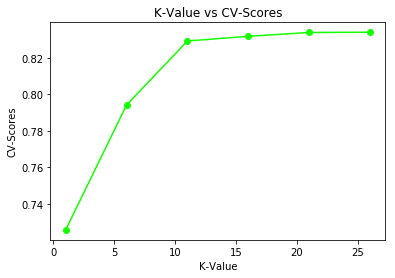

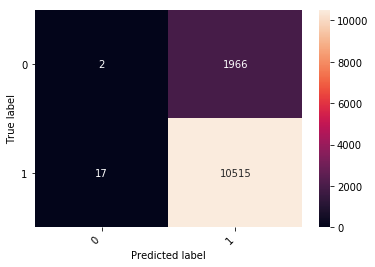

In [23]:
runKNN(X_Train,X_Test,y_train,y_test,'Bag of Words','kd_tree')


************************************************************************************************************************************************************************************************************************************************************************************************************
For K =  1 Accuracy Score =  0.7374645933813044
For K =  6 Accuracy Score =  0.8324799287959653
For K =  11 Accuracy Score =  0.8406134189871468
For K =  16 Accuracy Score =  0.8402135043015233
For K =  21 Accuracy Score =  0.8372001850538799
For K =  26 Accuracy Score =  0.8370401139389709
************************************************************************************************************************************************************************************************************************************************************************************************************

Details for  Bag of Words Vectorization:
Accuracy for brute  algorithm with K = 11  is  84.88
F1 score fo

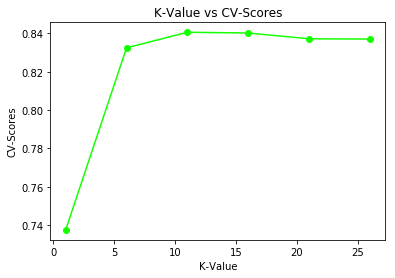

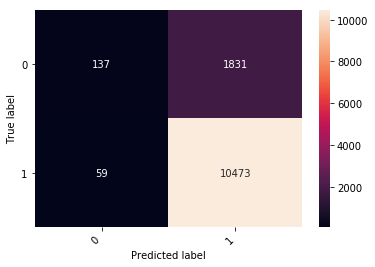

In [24]:
runKNN(X_Train,X_Test,y_train,y_test,'Bag of Words','brute')

**4.2 Using TF-IDF**

In [25]:
#Splitting into Training and Testing Set, and using only Training set for Word2Vec Training
X_Train,X_Test,y_train,y_test = train_test_split(final['Text'],final['Score'])

In [26]:
# Using on TRain Dataset for fitting the TFIDF
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
tfidf_Train = tf_idf_vect.fit_transform(X_Train.values)

# Using TRain fitted TFIDF to transform Test Dataset
tfidf_Test = tf_idf_vect.transform(X_Test.values)


#Check the structure of TFIDF transformed Train Dataset
print("the type of count vectorizer ",type(tfidf_Train))
print("the shape of out text TFIDF vectorizer ",tfidf_Train.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf_Train.get_shape()[1])


#Check the structure of TFIDF transformed Test Dataset
print("the type of count vectorizer ",type(tfidf_Test))
print("the shape of out text TFIDF vectorizer ",tfidf_Test.get_shape())
print("the number of unique words including both unigrams and bigrams ", tfidf_Test.get_shape()[1])

X_train_Vectorised = tfidf_Train
X_test_Vectorised = tfidf_Test
X_train_Vectorised = np.nan_to_num(X_train_Vectorised)
X_test_Vectorised = np.nan_to_num(X_test_Vectorised)

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (37500, 644934)
the number of unique words including both unigrams and bigrams  644934
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (12500, 644934)
the number of unique words including both unigrams and bigrams  644934


************************************************************************************************************************************************************************************************************************************************************************************************************
For K =  1 Accuracy Score =  0.7290933333333334
For K =  6 Accuracy Score =  0.7943733333333334
For K =  11 Accuracy Score =  0.8306666666666667
For K =  16 Accuracy Score =  0.8328
For K =  21 Accuracy Score =  0.8348533333333334
For K =  26 Accuracy Score =  0.8348266666666667
************************************************************************************************************************************************************************************************************************************************************************************************************

Details for  TF-IDF Vectorization:
Accuracy for kd_tree  algorithm with K = 21  is  84.02
F1 score for kd_tree  algor

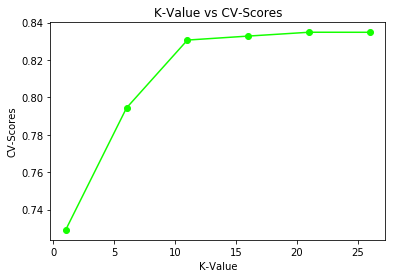

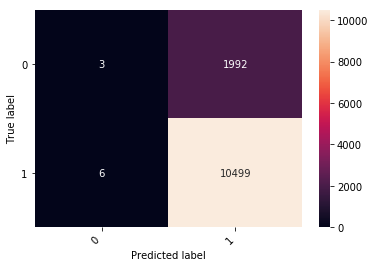

In [27]:
runKNN(X_train_Vectorised,X_test_Vectorised,y_train,y_test,'TF-IDF','kd_tree')

************************************************************************************************************************************************************************************************************************************************************************************************************
For K =  1 Accuracy Score =  0.82088
For K =  6 Accuracy Score =  0.8650666666666667
For K =  11 Accuracy Score =  0.8630133333333333
For K =  16 Accuracy Score =  0.8652
For K =  21 Accuracy Score =  0.8591733333333333
For K =  26 Accuracy Score =  0.8597066666666666
************************************************************************************************************************************************************************************************************************************************************************************************************

Details for  TF-IDF Vectorization:
Accuracy for brute  algorithm with K = 16  is  86.85
F1 score for brute  algorithm with K = 1

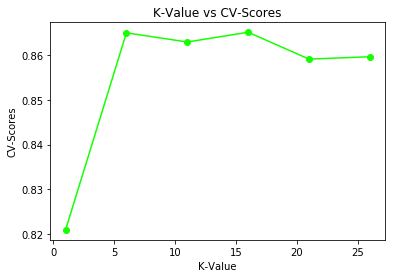

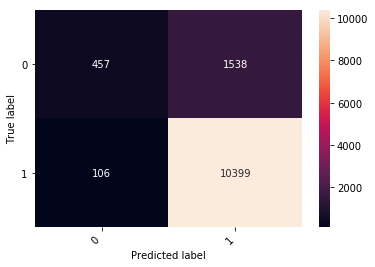

In [28]:
runKNN(X_train_Vectorised,X_test_Vectorised,y_train,y_test,'TF-IDF','brute')

**4.3 Using Average Word2Vec**

In [41]:
#Splitting into TRaining and Testing Set, and using only Training set for Word2Vec Training
X_Train,X_Test,y_train,y_test = train_test_split(final['Text'],final['Score'])


# Train your own Word2Vec model using your own text corpus

i=0
list_of_sent=[]
for sent in X_Train.values:
    filtered_sentence=[]
    sent=cleanhtml(sent)
    for w in sent.split():
        for cleaned_words in cleanpunct(w).split():
            if(cleaned_words.isalpha()):    
                filtered_sentence.append(cleaned_words.lower())
            else:
                continue 
    list_of_sent.append(filtered_sentence)
    

In [42]:
w2v_model=gensim.models.Word2Vec(list_of_sent,min_count=5,size=50, workers=4)    
words = list(w2v_model.wv.vocab)
#print(len(words))

In [43]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(X_Train): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

X_train_Vectorised = sent_vectors



sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in X_Test: # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        try:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
        except:
            pass
    sent_vec /= cnt_words
    sent_vectors.append(sent_vec)

X_test_Vectorised = sent_vectors
print(len(X_train_Vectorised))
print(len(X_test_Vectorised))


#np.where(np.isnan(X_test_Vectorised))
X_train_Vectorised = np.nan_to_num(X_train_Vectorised)
X_test_Vectorised = np.nan_to_num(X_test_Vectorised)
#np.nan_to_num(X_test_Vectorised)



100%|██████████| 37500/37500 [00:51<00:00, 722.99it/s]


37500
12500


************************************************************************************************************************************************************************************************************************************************************************************************************
For K =  1 Accuracy Score =  0.7306663783347943
For K =  6 Accuracy Score =  0.7918400752241831
For K =  11 Accuracy Score =  0.8306667353694863
For K =  16 Accuracy Score =  0.833146728298197
For K =  21 Accuracy Score =  0.8352266856466976
For K =  26 Accuracy Score =  0.8354133452117342
************************************************************************************************************************************************************************************************************************************************************************************************************

Details for  Average Word2Vec Vectorization:
Accuracy for kd_tree  algorithm with K = 26  is  83.74
F1 sco

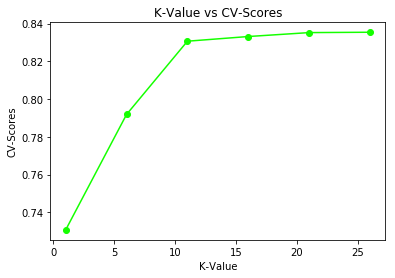

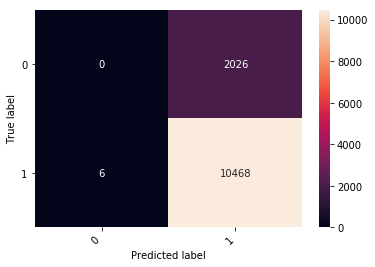

In [44]:
runKNN(X_train_Vectorised,X_test_Vectorised,y_train,y_test,'Average Word2Vec','kd_tree')

************************************************************************************************************************************************************************************************************************************************************************************************************
For K =  1 Accuracy Score =  0.7315998468152779
For K =  6 Accuracy Score =  0.792026756113073
For K =  11 Accuracy Score =  0.8306667353694863
For K =  16 Accuracy Score =  0.8331200687407456
For K =  21 Accuracy Score =  0.8352266856466976
For K =  26 Accuracy Score =  0.8354133452117342
************************************************************************************************************************************************************************************************************************************************************************************************************

Details for  Average Word2Vec Vectorization:
Accuracy for brute  algorithm with K = 26  is  83.74
F1 score

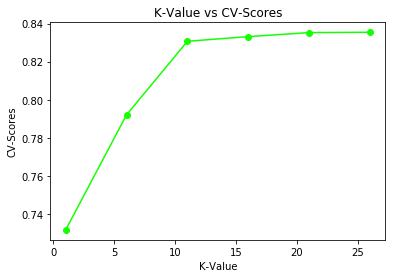

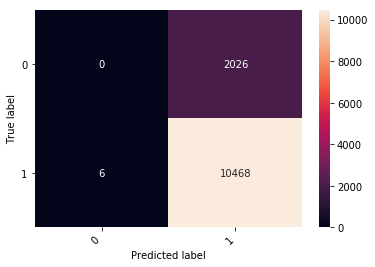

In [45]:
runKNN(X_train_Vectorised,X_test_Vectorised,y_train,y_test,'Average Word2Vec','brute')

**4.4 Using TF-IDF Weighted Word2Vec**

In [46]:
#Splitting into TRaining and Testing Set, and using only Training set for Word2Vec Training
X_Train,X_Test,y_train,y_test = train_test_split(final['CleanedText'],final['Score'])

# TF-IDF weighted Word2Vec
vect_tfidf = TfidfVectorizer(min_df = 5).fit(X_Train)
tfidf_feat = vect_tfidf.get_feature_names() # tfidf words/col-names
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_feat, list(vect_tfidf.idf_)))
#print(tfidf_feat)
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_Train): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_model:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

X_train_Vectorised = tfidf_sent_vectors


tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(X_Test): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_model:
            vec = w2v_model.wv[word]
#           tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1



X_test_Vectorised = tfidf_sent_vectors
    
X_train_Vectorised = np.nan_to_num(X_train_Vectorised)
X_test_Vectorised = np.nan_to_num(X_test_Vectorised)

100%|██████████| 12500/12500 [00:09<00:00, 1321.44it/s]


************************************************************************************************************************************************************************************************************************************************************************************************************
For K =  1 Accuracy Score =  0.8378400048033189
For K =  6 Accuracy Score =  0.8378400048033189
For K =  11 Accuracy Score =  0.8378400048033189
For K =  16 Accuracy Score =  0.8378400048033189
For K =  21 Accuracy Score =  0.8378400048033189
For K =  26 Accuracy Score =  0.8378400048033189
************************************************************************************************************************************************************************************************************************************************************************************************************

Details for  TF-IDF Weighted Word2Vec Vectorization:
Accuracy for kd_tree  algorithm with K = 1  is  16.8

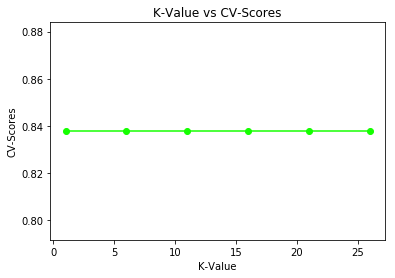

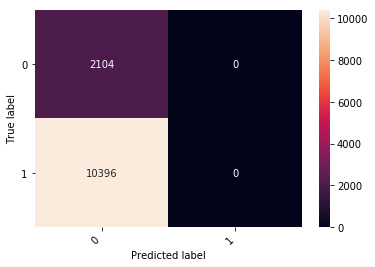

In [47]:
runKNN(X_train_Vectorised,X_test_Vectorised,y_train,y_test,'TF-IDF Weighted Word2Vec','kd_tree')

************************************************************************************************************************************************************************************************************************************************************************************************************
For K =  1 Accuracy Score =  0.2296886542209413
For K =  6 Accuracy Score =  0.567555320887608
For K =  11 Accuracy Score =  0.7702666714699855
For K =  16 Accuracy Score =  0.7702666714699855
For K =  21 Accuracy Score =  0.7702666714699855
For K =  26 Accuracy Score =  0.7702666714699855
************************************************************************************************************************************************************************************************************************************************************************************************************

Details for  TF-IDF Weighted Word2Vec Vectorization:
Accuracy for brute  algorithm with K = 11  is  83.17


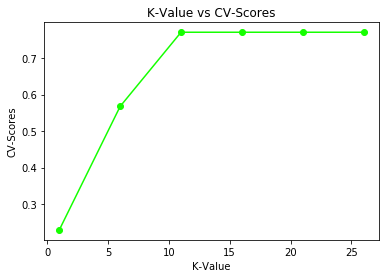

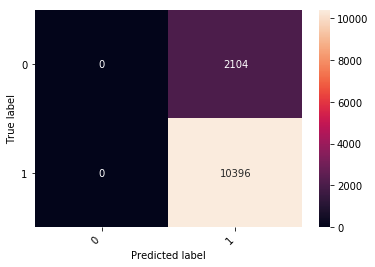

In [48]:
runKNN(X_train_Vectorised,X_test_Vectorised,y_train,y_test,'TF-IDF Weighted Word2Vec','brute')

### 5. Conclusion


In [49]:
Final_Metrics

,Algorithm,HyperParameter,Testing Accuracy Score,Training Accuracy Score,Vectorization
0,kd_tree,26.0,84.136,83.440000,Bag of Words
1,brute,11.0,84.880,84.954667,Bag of Words
2,kd_tree,21.0,84.016,83.501333,TF-IDF
3,brute,16.0,86.848,87.469333,TF-IDF
4,kd_tree,26.0,83.536,83.661333,Average Word2Vec
5,brute,21.0,83.536,83.682667,Average Word2Vec
6,kd_tree,1.0,83.288,83.744000,TF-IDF Weighted Word2Vec
7,brute,1.0,83.288,83.744000,TF-IDF Weighted Word2Vec
8,kd_tree,26.0,83.744,83.562667,Average Word2Vec
9,brute,26.0,83.744,83.562667,Average Word2Vec


#### The Above table shows that KNN run using TF-IDF Vectorization technique with Brute Force Technique results in the highest Testing Accuracy of 86.848%  with a K-value of 16.

#### From the Confusion Matrices we can observe that majority of the models predict the class as Positive and has a very high value of False Positives. This is because the dataset we have considered, is highly unbalanced with more than 80% of datapoints belonging to the Positive Class.